In [1]:
import matplotlib.pyplot as plt
import json
import os
import matplotlib

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Input Assumptions

The model was run 50 times for the SSEB, for incrementally increasing VoLL values. For each of the 50 runs constraints were set such that the load must be met with solar PV + BESS for 25-26 consecutive two-week outage periods. The worst-case set of 2 week outage periods was determined to begin at 4pm on Tuesday, January 1st, 2019. Each scenario provides the minimum cost system that either meets the critical load in all of the 2 week outages modeled, or pays for the total unserved load not met during the set of 2 week outages.

In [3]:
pv_cost_per_kw = 1600
batt_cost_per_kw = 840
batt_cost_per_kwh = 420
VoLL = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
       21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]

{  
  "PV": {
    "macrs_option_years": 5,
    "existing_kw": 16,
    "macrs_bonus_pct": 1.0,
    "total_itc_pct": 0.26
  },
  "Storage": {
    "macrs_option_years": 5,
    "can_grid_charge": False,
    "total_itc_pct": 0.26,
    "replace_cost_per_kw": 410.0,  # in year 10
    "replace_cost_per_kwh": 200.0
  },
  "Financial": {
    "microgrid_premium_pct": 0.3,
    "analysis_years": 25,
    "om_cost_escalation_pct": 0.025,
    "elec_cost_escalation_pct": 0.023,
    "offtaker_tax_pct": 0.26,
    "owner_discount_pct": 0.1,
    "offtaker_discount_pct": 0.03,
    "two_party_ownership": True,
    "offtaker_tax_pct": 0.0
  }
};

In [4]:
results_dir = "sseb_results"
bau_results_dir = "bau_results"
plt_prefix = "sseb"

In [5]:
results = []
for j in [f for f in os.listdir(results_dir) if f.startswith("sseb_VoLL")]:
    results.append(json.load(open(os.path.join(results_dir, j), 'r')))

pvs_kw = [r["PV_kw"] for r in results]
batt_kws = [r["batt_kw"] for r in results]
batt_kwhs = [r["batt_kwh"] for r in results]

net_capital_costs = [r["net_capital_costs"] for r in results]

total_system_cap_costs = [r["net_capital_costs"] + r["microgrid_upgrade_costs"] for r in results]

max_unserved_load = [r["max_unserved_load"] for r in results]

batt_upfront_costs = 1.3*(batt_kws*batt_cost_per_kw + batt_kwhs*batt_cost_per_kwh)

upfront_costs = []

for pv,bkw,bkwh in zip(pvs_kw, batt_kws, batt_kwhs):
    upfront_costs.append( 1.3 *
        (pv*pv_cost_per_kw + bkw*batt_cost_per_kw + bkwh*batt_cost_per_kwh)
    )


bau_results = []    
for j in [f for f in os.listdir(bau_results_dir) if f.startswith("sseb_BAU")]:
    bau_results.append(json.load(open(os.path.join(bau_results_dir, j), 's')))  

utility_bill_savings = [s["year_one_bill"] for s in bau_results - r["year_one_bill"] for r in results]
# lenghts are different - replace bau year_one_bill manually with 2.3966e6?

demand_savings = [s["year_one_demand_cost"] for s in bau_results - r["year_one_demand_cost"] for r in results]
# lenghts are different - replace bau year_one_demand_cost manually with 1.217e6?

energy_savings = [s["year_one_energy_cost"] for s in bau_results - r["year_one_energy_cost"] for r in results]
# lenghts are different - replace bau year_one_energy_cost manually with 1.1796e6?

outage_savings = [s["max_outage_cost"] for s in bau_results - r["max_outage_cost"] for r in results]
# lenghts are different - replace bau max_outage_cost manually with 7.335e6?

npv = [s["lcc"] for s in bau_results - r["lcc"] for r in results]
# lenghts are different - replace bau lcc manually with 6.3478e7?

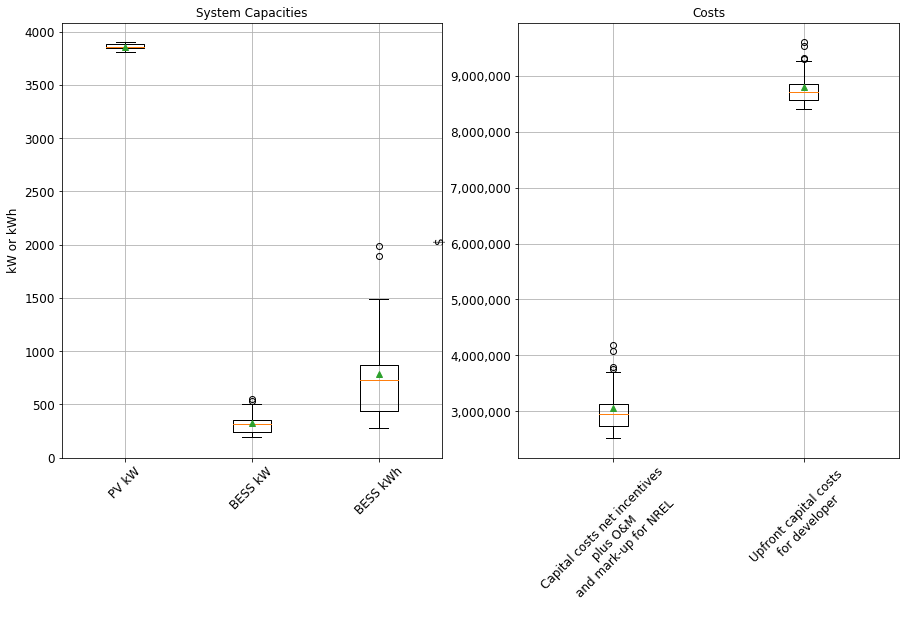

In [6]:
fig, axes = plt.subplots(1,2, figsize=(15, 8))
miny = 0

axes[0].set_title("System Capacities")
bp = axes[0].boxplot([
    pvs_kw, 
    batt_kws,
    batt_kwhs,
], showmeans=True)

ylims = axes[0].get_ylim()
axes[0].set_ylim((miny, ylims[1]))

axes[1].set_title("Costs")
bp = axes[1].boxplot([
    net_capital_costs, 
    upfront_costs
], showmeans=True)

# axes[1].set_ylim((miny, ylims[1]))

for ax in axes:
    ax.grid()

    
axes[0].set_xticklabels(["PV kW", 
                    "BESS kW",
                    "BESS kWh",
                    ], 
                   rotation=45
                  )
axes[0].set_ylabel("kW or kWh", fontsize=BIGGER_SIZE)

axes[1].set_xticklabels(["Capital costs net incentives\n and mark-up for NREL", 
                         "Upfront capital costs \nfor developer"
                    ], 
                   rotation=45
                  )
axes[1].set_ylabel("$", fontsize=BIGGER_SIZE)


axes[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# plt.title("time_compare_test_generator_big_enough_for_outage")
#     ax.set_xlim((-500, 500))
plt.savefig(plt_prefix+"_2wk_outages_robust_for_24_per_year.pdf", bbox_inches="tight")

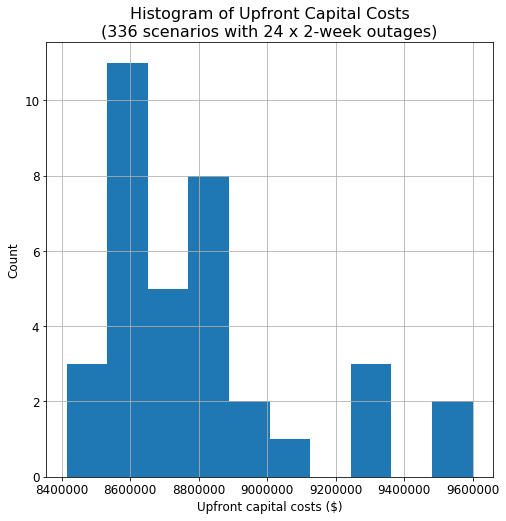

In [7]:
plt.figure(figsize=(8,8))
plt.hist(upfront_costs)
plt.xlabel("Upfront capital costs ($)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Histogram of Upfront Capital Costs\n(336 scenarios with 24 x 2-week outages)",
         fontsize=16)
plt.grid()
plt.savefig(plt_prefix+"_hist_upfront_costs.pdf", bbox_inches="tight")

Notes: 
- upfront capital costs include 30% microgrid cost-adder to the default cost values.
- Cost to NREL includes developer's IRR as well as developer's tax benefits (ITC, MACRS)
- Existing 16 kW of PV is included in the capacities plot (but is not part of costs)

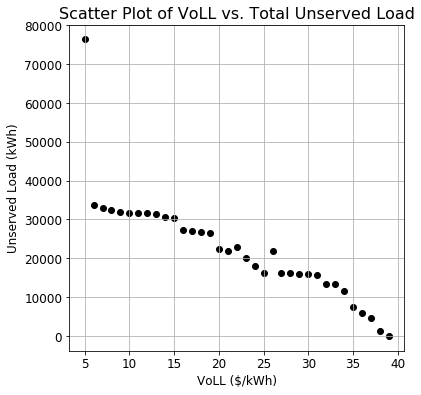

In [8]:
plt.figure(figsize=(8,8)
plt.scatter(VoLL, max_unserved_load, c=batt_upfront_costs, marker ='o')
#add batt upfront costs as third label in 2-D scatter plot, but no way to label. Produce 3-D plot instead?
plt.xlabel("VoLL ($/kWh)", fontsize=12)
plt.ylabel("Unserved Load (kWh)", fontsize=12)
plt.title("Scatter Plot of VoLL vs. Total Unserved Load vs. Batt Upfront Costs", fontsize=16)
plt.grid()
plt.savefig(plt_prefix+"_VoLL_vs_total_unserved_load_vs_batt_upfront_costs.pdf", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,8)
plt.scatter(batt_upfront_costs, utility_bill_savings, color="black", marker ='o')
plt.xlabel("Upfront Battery Costs", fontsize=12)
plt.ylabel("Utility Bill Savings", fontsize=12)
plt.title("Battery Costs vs. Utility Bill Savings", fontsize=16)
plt.grid()
plt.savefig(plt_prefix+"_battery_costs_vs_utility_bill_savings.pdf", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,8)
plt.scatter(batt_upfront_costs, demand_savings, color="black", marker ='o')
plt.xlabel("Upfront Battery Costs", fontsize=12)
plt.ylabel("Demand Savings", fontsize=12)
plt.title("Battery Costs vs. Demand Savings", fontsize=16)
plt.grid()
plt.savefig(plt_prefix+"_battery_costs_vs_demand_savings.pdf", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,8)
plt.scatter(batt_upfront_costs, energy_savings, color="black", marker ='o')
plt.xlabel("Upfront Battery Costs", fontsize=12)
plt.ylabel("Energy Savings", fontsize=12)
plt.title("Battery Costs vs. Energy Savings", fontsize=16)
plt.grid()
plt.savefig(plt_prefix+"_battery_costs_vs_energy_savings.pdf", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,8)
plt.scatter(batt_upfront_costs, outage_savings, color="black", marker ='o')
plt.xlabel("Upfront Battery Costs", fontsize=12)
plt.ylabel("Outage Savings", fontsize=12)
plt.title("Battery Costs vs. Outage Savings", fontsize=16)
plt.grid()
plt.savefig(plt_prefix+"_battery_costs_vs_outage_savings.pdf", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,8)
plt.scatter(total_system_cap_costs, utility_bill_savings, color="black", marker ='o')
plt.xlabel("Total System Capital Costs", fontsize=12)
plt.ylabel("Utility Bill Savings", fontsize=12)
plt.title("Total System Costs vs. Outage Savings", fontsize=16)
plt.grid()
plt.savefig(plt_prefix+"_system_costs_vs_utility_bill_savings.pdf", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,8)
plt.scatter(total_system_cap_costs, npv, color="black", marker ='o')
plt.xlabel("Total System Capital Costs", fontsize=12)
plt.ylabel("Net Present Value", fontsize=12)
plt.title("Total System Costs vs. Net Present Value", fontsize=16)
plt.grid()
plt.savefig(plt_prefix+"_system_costs_vs_net_present_value.pdf", bbox_inches="tight")